# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import datetime
import json
import seaborn as sns
import joblib
import datetime
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import scale
import pandas_datareader.data as web

C:\Users\aritc\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Collect the required data 

In [2]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()
dataset = web.DataReader("SPY", "yahoo", start, end)

dataset = dataset.shift(1)

In [3]:
asset = "SPY"
column_price = 'Close'
column_high = 'High'
column_low = 'Low'
column_volume = 'Volume'

# Visualize SPY closing prices and volume

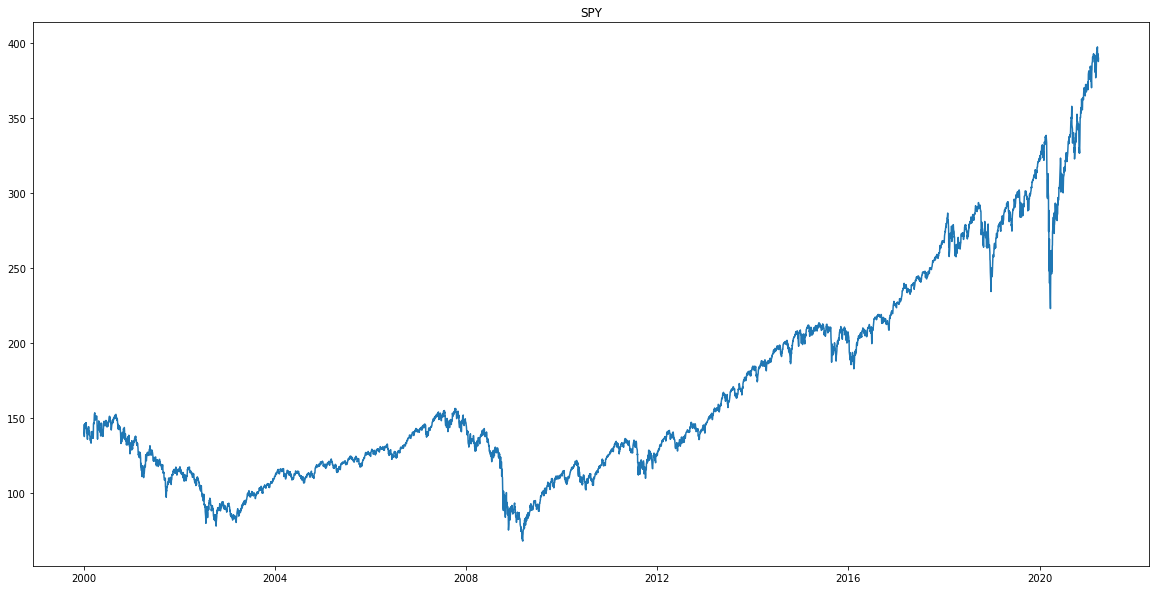

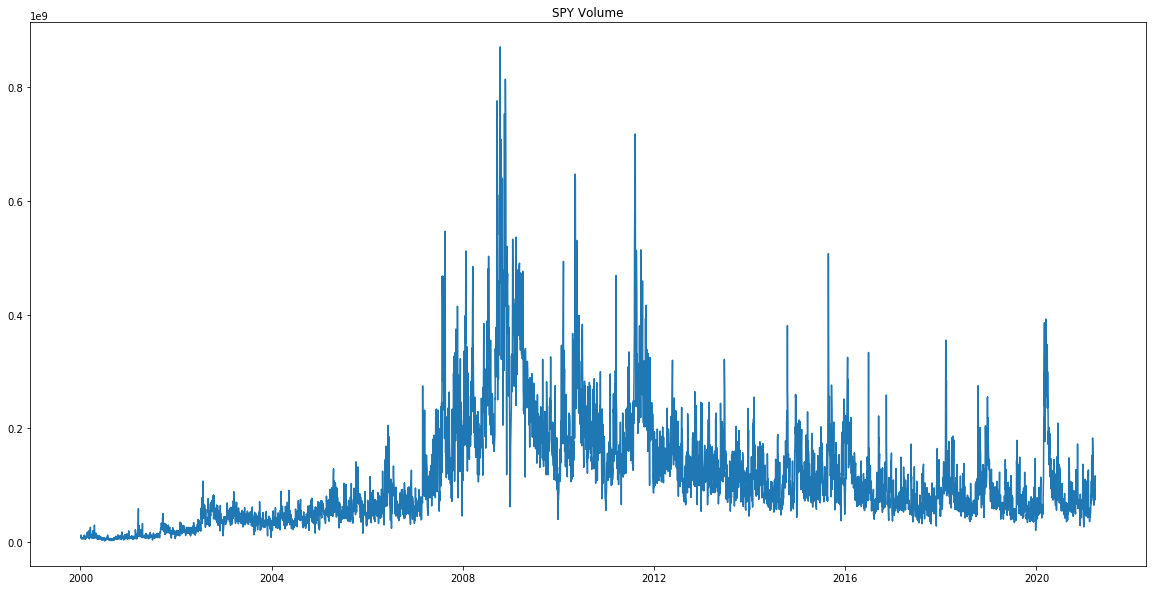

In [4]:
plt.figure(figsize=(20,10))
plt.plot(dataset[column_price])
plt.title(asset)
plt.show()
    
plt.figure(figsize=(20,10))
plt.plot(dataset[column_volume])
plt.title(asset + " Volume")
plt.show()

# Brute force modelling using Hidden Markov Model

In [5]:
def get_best_hmm_model(X, max_states, max_iter = 10000):
    best_score = -(10 ** 10)
    best_state = 0
    
    for state in range(1, max_states + 1):
        hmm_model = GaussianHMM(n_components = state, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
        if hmm_model.score(X) > best_score:
            best_score = hmm_model.score(X)
            best_state = state
    
    best_model = GaussianHMM(n_components = best_state, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
    return best_model

# Normalized std dev
def std_normalized(vals):
    return np.std(vals) / np.mean(vals)

# Ratio of difference between last price and mean value to last price
def ma_ratio(vals):
    return (vals[-1] - np.mean(vals)) / vals[-1]

# z-score for volumes and price
def values_deviation(vals):
    return (vals[-1] - np.mean(vals)) / np.std(vals)

<Figure size 1440x720 with 0 Axes>

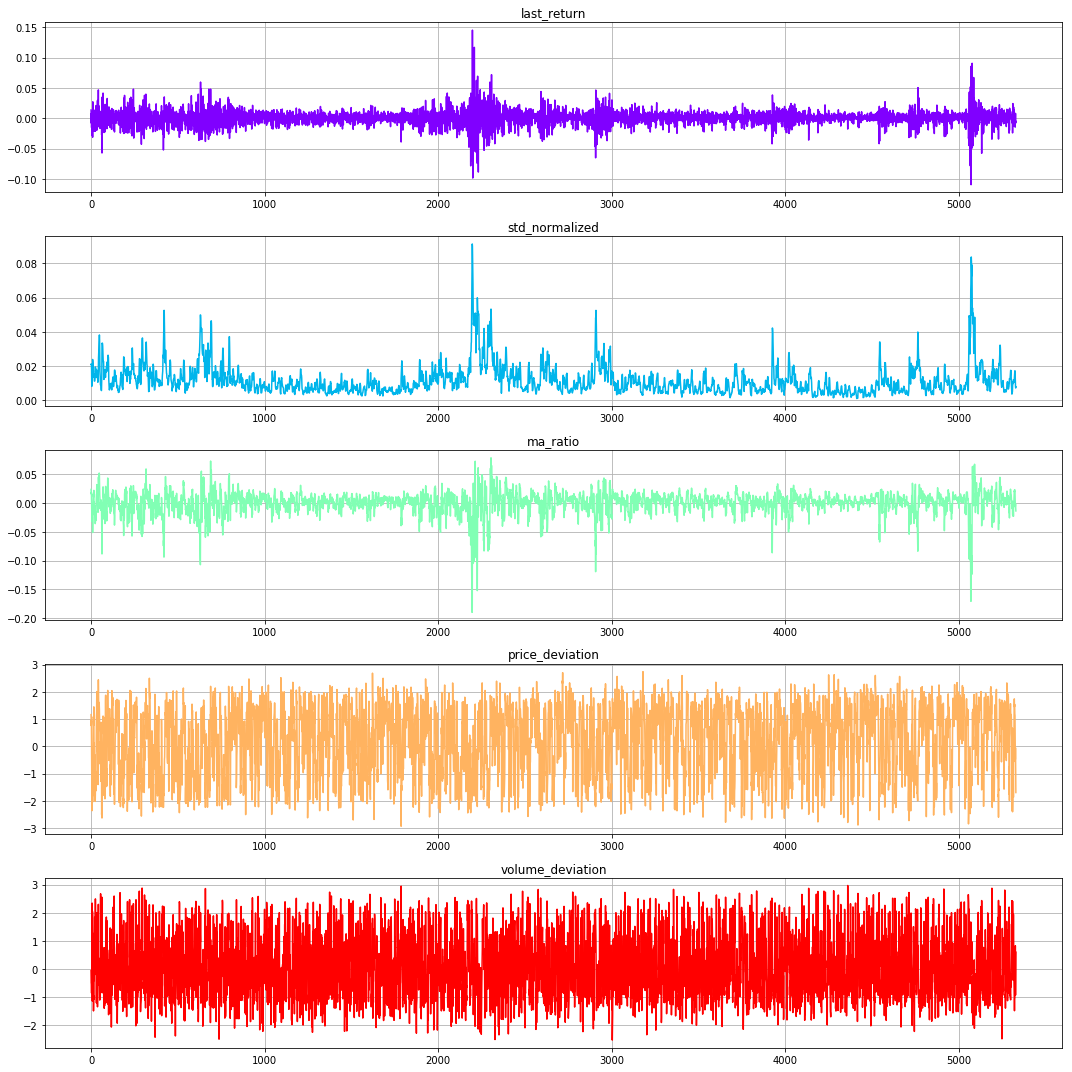

In [6]:
# Feature parameters
future_period = 1

# Averaging parameteres
std_period = 10
ma_period = 10
price_deviation_period = 10
volume_deviation_period = 10

# Create features
feature_cols = ['last_return', 'std_normalized', 'ma_ratio', 'price_deviation', 'volume_deviation']

dataset['last_return'] = dataset[column_price].pct_change()
dataset['std_normalized'] = dataset[column_price].rolling(std_period).apply(std_normalized)
dataset['ma_ratio'] = dataset[column_price].rolling(ma_period).apply(ma_ratio)
dataset['price_deviation'] = dataset[column_price].rolling(price_deviation_period).apply(values_deviation)
dataset['volume_deviation'] = dataset[column_volume].rolling(volume_deviation_period).apply(values_deviation)

dataset["future_return"] = dataset[column_price].pct_change(future_period).shift(-future_period)

dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

# Split the data on sets
train_index = int(np.where(dataset.index == '2021-03-15')[0])
train_set = dataset[feature_cols].values[:train_index]
test_set = dataset[feature_cols].values[train_index:]

# Plot features
plt.figure(figsize=(20,10))
fig, axs = plt.subplots(len(feature_cols), 1, figsize = (15, 15))
colours = cm.rainbow(np.linspace(0, 1, len(feature_cols)))
for i in range(0, len(feature_cols)):
    axs[i].plot(dataset.reset_index()[feature_cols[i]], color = colours[i])
    axs[i].set_title(feature_cols[i])
    axs[i].grid(True)

plt.tight_layout()

# Plot hidden states

C:\Users\aritc\Anaconda3\lib\site-packages\pandas\core\indexes\range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
C:\Users\aritc\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aritc\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\aritc\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for mu

<Figure size 1080x1080 with 0 Axes>

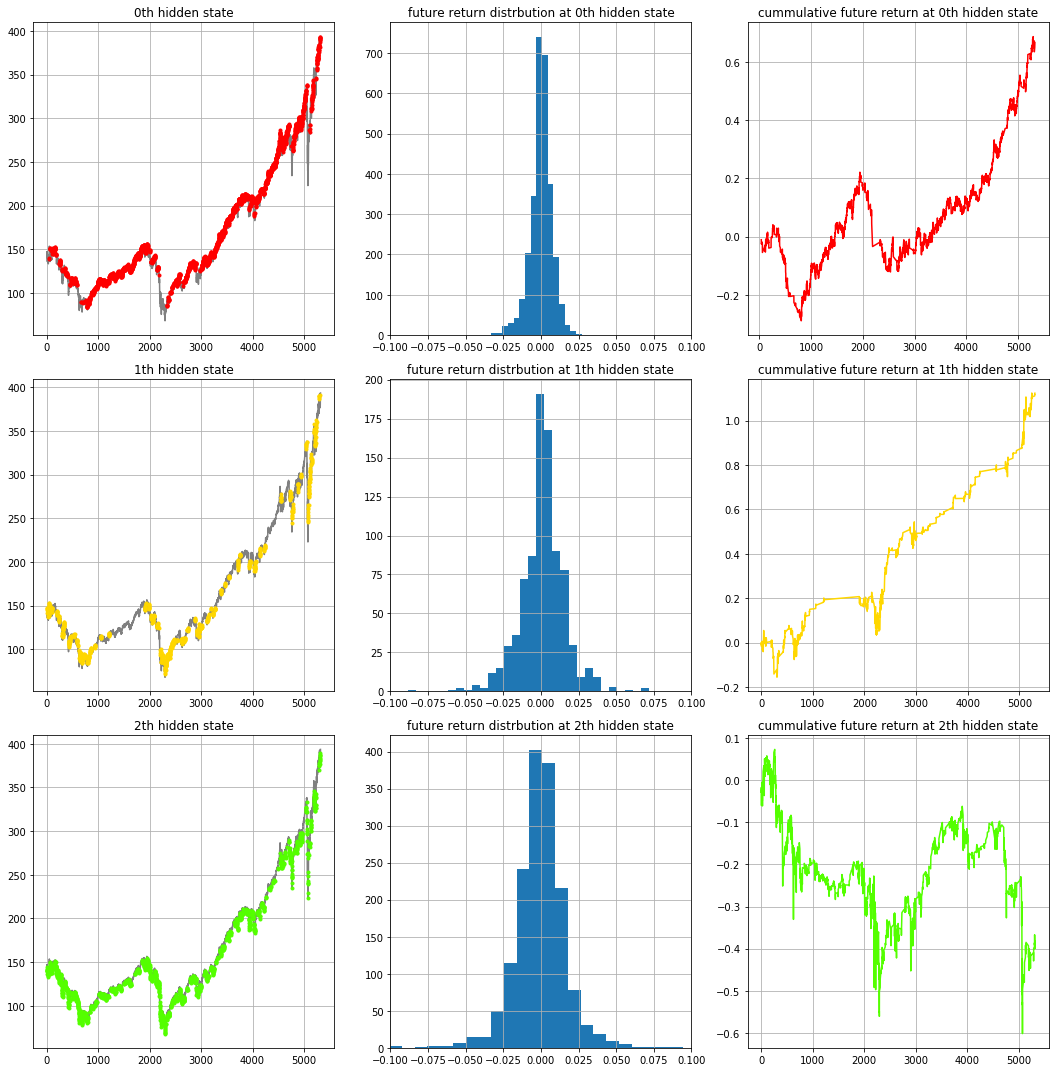

In [7]:

def plot_hidden_states(hmm_model, data, X, column_price):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    hidden_states = model.predict(X)
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data[column_price], c = 'grey')
        ax[0].plot(data.index[mask], data[column_price][mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(data["future_return"][mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)
        
    plt.tight_layout()


model = get_best_hmm_model(X = train_set, max_states = 3, max_iter = 1000000)
plot_hidden_states(model, dataset[:train_index].reset_index(), train_set, column_price)

# Looking at the above, we can interpret the states as being:

# State 1: Cautiously Long
# State 2: Long
# State 3: Short

<Figure size 1080x1080 with 0 Axes>

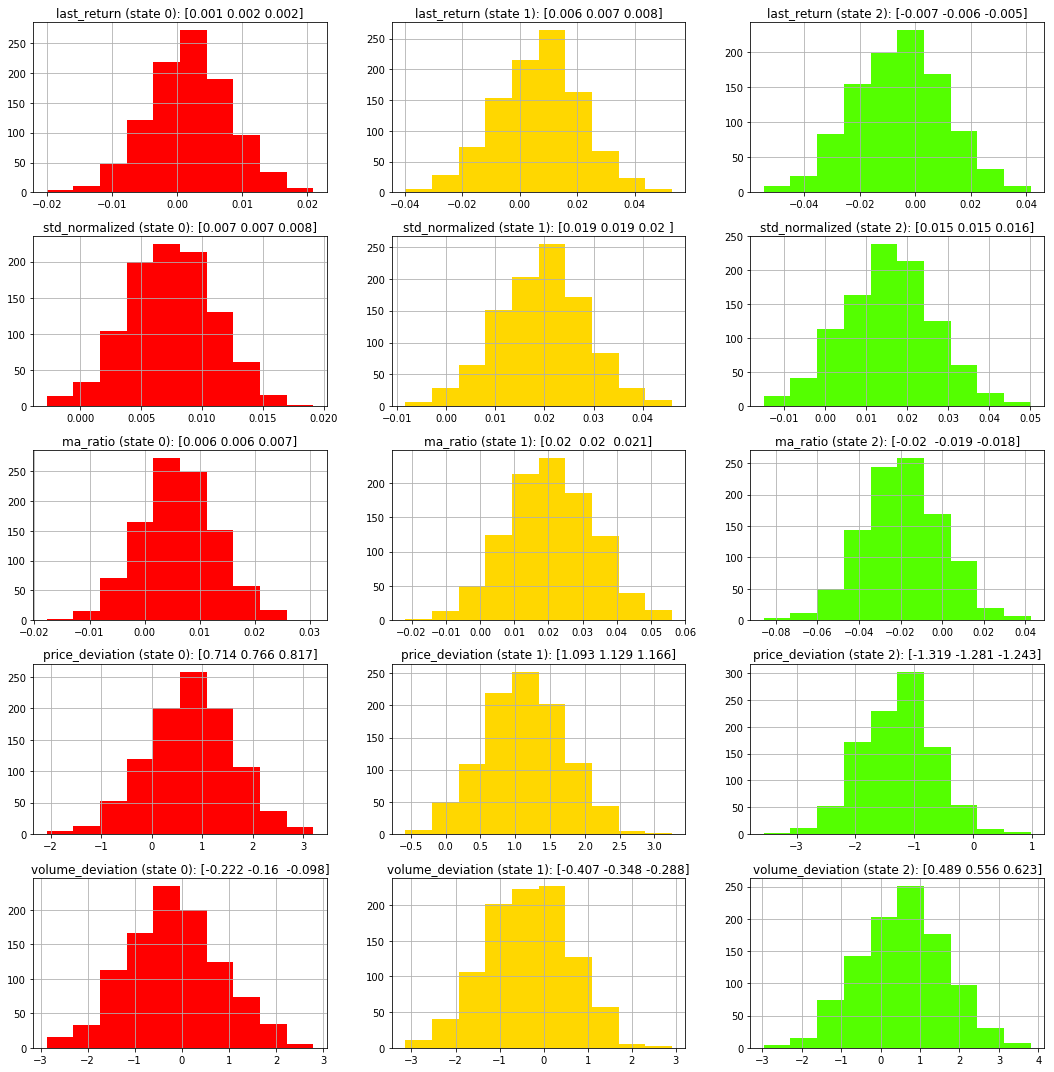

In [8]:
def mean_confidence_interval(vals, confidence):
    a = 1.0 * np.array(vals)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m - h, m, m + h

def compare_hidden_states(hmm_model,feature_cols, conf_interval, iters = 1000):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(len(feature_cols), hmm_model.n_components, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    
    for i in range(0, model.n_components):
        mc_df = pd.DataFrame()
    
        # Samples generation
        for j in range(0, iters):
            row = np.transpose(hmm_model._generate_sample_from_state(i))
            mc_df = mc_df.append(pd.DataFrame(row).T)
        mc_df.columns = feature_cols
    
        for k in range(0, len(mc_df.columns)):
            axs[k][i].hist(mc_df[feature_cols[k]], color = colours[i])
            axs[k][i].set_title(feature_cols[k] + " (state " + str(i) + "): " + str(np.round(mean_confidence_interval(mc_df[feature_cols[k]], conf_interval), 3)))
            axs[k][i].grid(True)
            
    plt.tight_layout()
    
compare_hidden_states(hmm_model=model, feature_cols=feature_cols, conf_interval=0.95)

In [9]:
#joblib.dump(model, 'HMM' + asset.replace('/', '_') + '_final_model.pkl')

In [10]:
#model.transmat_